# Autoencoders

# 2 types of autoencoders to try

1. Vanilla (one layer) autoencoders 
2. Multilayer autoencoder

**all with softmax to classify (all gave same results 50% f-score)
without smote just standardised the dataset using StandardScaler fitting it only on the training data to prevent data leakage and then applying the same transformation to the validation and test set

SMOTE gave a slightly better result 52% (f-score)
**The code with smote repeats the same preprocessing technique as before with the scaling^^ so to run that section you would need to run the import libraries then the cell below it then the code in the smote section no need to runn all code since it will split 

## Import the libraries

In [96]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler

## Load the data

We don't need the labels as the autoencoders are unsupervised network

## Preprocess

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = r'C:\Users\l_alm\resnet1d-master\content\customerTargeting.csv'
df = pd.read_csv(data)
X = df.drop(columns=["target"])
y=df["target"]

# 80% (train + validation) and 20% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 60% (train) and 20% (validation) from the 80% data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


#the final sizes
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")




Train: 3972, Validation: 1324, Test: 1324


# If you're going to run SMOTE section please dont run this cell below

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only on training data

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)  # Apply same transformation
X_test = scaler.transform(X_test)  # Apply same transformation


# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers Input - encoder - decoder

In [11]:
input_size = 70
hidden_size = 1000
bottleneck_size = 1000
output_size = 70

In [16]:


input_layer = Input(shape=(input_size,))

encoder = Dense(hidden_size, activation="relu")(input_layer)


bottleneck = Dense(bottleneck_size, activation="relu")(encoder) 


decoder = Dense(hidden_size, activation="relu")(bottleneck)

output_layer = Dense(input_size, activation="sigmoid")(decoder)  

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

### Train

In [17]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, validation_data=(X_val, X_val), shuffle=True, callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 1s 27ms/step - loss: 0.7538 - val_loss: 0.6681
Epoch 2/200
32/32 [==============================] - 1s 21ms/step - loss: 0.6419 - val_loss: 0.6116
Epoch 3/200
32/32 [==============================] - 1s 23ms/step - loss: 0.5995 - val_loss: 0.5922
Epoch 4/200
32/32 [==============================] - 1s 22ms/step - loss: 0.5887 - val_loss: 0.5874
Epoch 5/200
32/32 [==============================] - 1s 22ms/step - loss: 0.5856 - val_loss: 0.5838
Epoch 6/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5826 - val_loss: 0.5833
Epoch 7/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5820 - val_loss: 0.5803
Epoch 8/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5796 - val_loss: 0.5828
Epoch 9/200
32/32 [==============================] - 1s 21ms/step - loss: 0.5799 - val_loss: 0.5795
Epoch 10/200
32/32 [==============================] - 1s 22ms/step - loss: 0.5787 - val_loss: 0.5775

### Predict on the test set

In [18]:
decoded = autoencoder.predict(X_test)

42/42 [==============================] - 0s 6ms/step


### Plot

### Plot the losses

dict_keys(['loss', 'val_loss'])


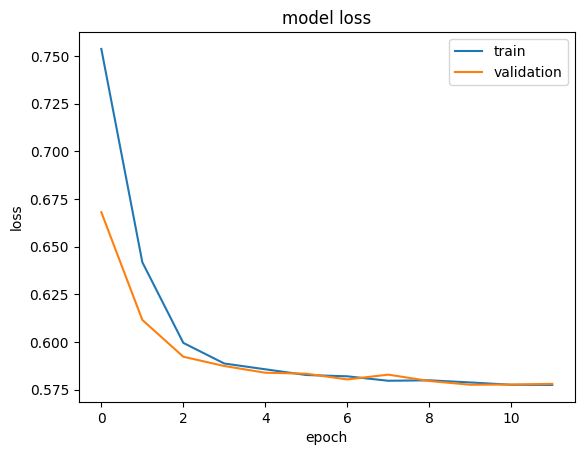

In [19]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
from keras.models import Model

#extracting encoder part from trained autoencoder
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)  #bottleneck layer


In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

#defining a classifier using the encoded features
classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')


In [29]:



#compute class weights
#class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))} improves performance in classes 0 and 2 but lowers the performance
#print("class Weights:", class_weights_dict)
# Train classifier
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 
history=classifier.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val), shuffle=True)



Epoch 1/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9074 - val_loss: 0.9397
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.9066 - val_loss: 0.9411
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9116 - val_loss: 0.9430
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9073 - val_loss: 0.9424
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9070 - val_loss: 0.9408
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9063 - val_loss: 0.9410
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9066 - val_loss: 0.9421
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9073 - val_loss: 0.9429
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9082 - val_loss: 0.9410
Epoch 10/200
32/32 [==============================] - 0s 4ms/step - loss: 0.9065 - val_loss: 0.9407
Epoch 11/

dict_keys(['loss', 'val_loss'])


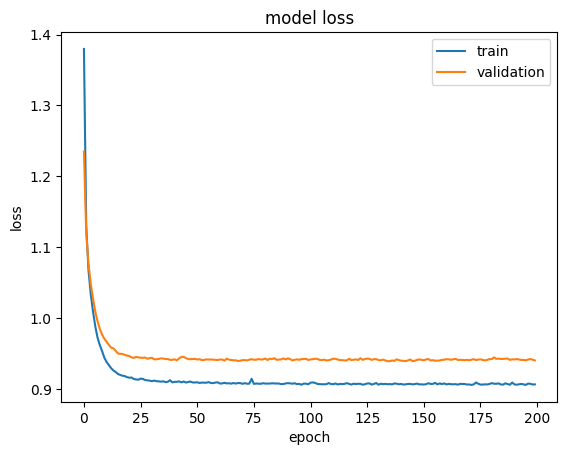

In [27]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))


42/42 [==============================] - 0s 954us/step
              precision    recall  f1-score   support

           0     0.3871    0.0366    0.0669       328
           1     0.5906    0.8692    0.7033       604
           2     0.5644    0.5816    0.5729       392

    accuracy                         0.5778      1324
   macro avg     0.5140    0.4958    0.4477      1324
weighted avg     0.5324    0.5778    0.5070      1324



---

# **Multilayer autoencoder**

trying 2 layers 

In [31]:
input_size = 70
hidden_size1= 1000
hidden_size2= 1000
bottleneck_size= 1000
output_size = 70

input_layer = Input(shape=(input_size,))
encoder = Dense(hidden_size1, activation="relu")(input_layer)
encoder = Dense(hidden_size2, activation="relu")(encoder)
bottleneck = Dense(bottleneck_size, activation="relu")(encoder)  


decoder = Dense(hidden_size2, activation="relu")(bottleneck)
decoder = Dense(hidden_size1, activation="relu")(decoder)
output_layer = Dense(output_size, activation="sigmoid")(decoder) 

autoencoder2 = Model(inputs=input_layer, outputs=output_layer)
autoencoder2.compile(optimizer='adam', loss='mse')

### Train the network

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder2.fit(X_train, X_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_val, X_val), shuffle=True,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 3s 60ms/step - loss: 0.7908 - val_loss: 0.7259
Epoch 2/200
32/32 [==============================] - 2s 53ms/step - loss: 0.7157 - val_loss: 0.7052
Epoch 3/200
32/32 [==============================] - 2s 54ms/step - loss: 0.6932 - val_loss: 0.6803
Epoch 4/200
32/32 [==============================] - 2s 60ms/step - loss: 0.6667 - val_loss: 0.6572
Epoch 5/200
32/32 [==============================] - 2s 58ms/step - loss: 0.6439 - val_loss: 0.6467
Epoch 6/200
32/32 [==============================] - 2s 54ms/step - loss: 0.6247 - val_loss: 0.6214
Epoch 7/200
32/32 [==============================] - 2s 56ms/step - loss: 0.6112 - val_loss: 0.6065
Epoch 8/200
32/32 [==============================] - 2s 54ms/step - loss: 0.6006 - val_loss: 0.6020
Epoch 9/200
32/32 [==============================] - 2s 55ms/step - loss: 0.5966 - val_loss: 0.5957
Epoch 10/200
32/32 [==============================] - 2s 58ms/step - loss: 0.5918 - val_loss: 0.5955

### Predict on the test set

In [33]:
decoded_output= autoencoder2.predict(X_test)

42/42 [==============================] - 1s 10ms/step


### Plot the losses

dict_keys(['loss', 'val_loss'])


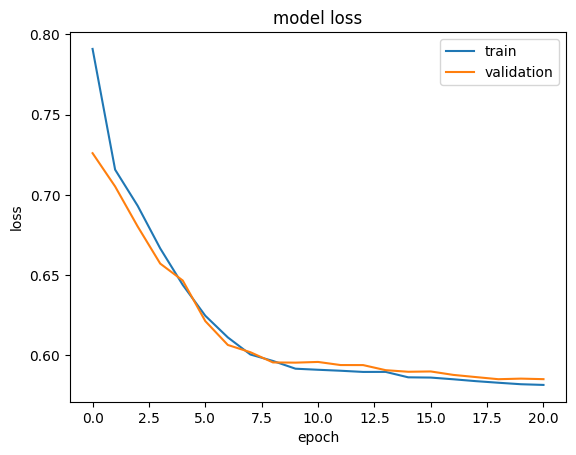

In [34]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [36]:
encoder_model = Model(inputs=autoencoder2.input, outputs=autoencoder2.get_layer(index=3).output)  #bottleneck layer

In [37]:
#defining a classifier using the encoded features
classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

# Compile the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')


In [39]:

#compute class weights
#class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))} improves performance in classes 0 and 2 but lowers the performance
#print("class Weights:", class_weights_dict)
# Train classifier
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) 
history=classifier.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val), shuffle = True,callbacks=[early_stopping])



Epoch 1/200
32/32 [==============================] - 0s 6ms/step - loss: 1.5233 - val_loss: 1.3188
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2028 - val_loss: 1.1672
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 1.1182 - val_loss: 1.1268
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0807 - val_loss: 1.0988
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0531 - val_loss: 1.0729
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0307 - val_loss: 1.0538
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0128 - val_loss: 1.0387
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9969 - val_loss: 1.0249
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9868 - val_loss: 1.0131
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9741 - val_loss: 1.0053
Epoch 11/

# plot

dict_keys(['loss', 'val_loss'])


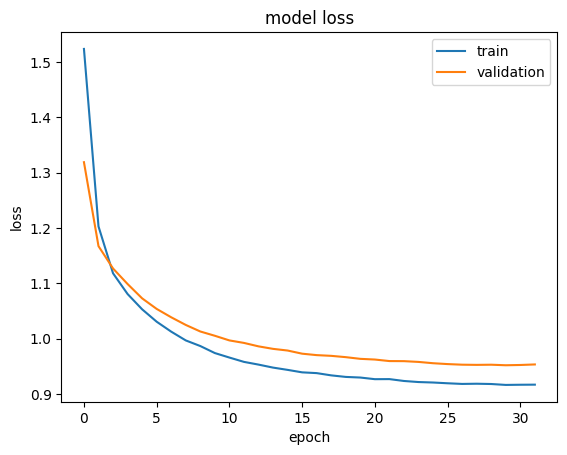

In [40]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [42]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.3243    0.0366    0.0658       328
           1     0.5844    0.8659    0.6978       604
           2     0.5765    0.5765    0.5765       392

    accuracy                         0.5748      1324
   macro avg     0.4951    0.4930    0.4467      1324
weighted avg     0.5176    0.5748    0.5053      1324



# Trying 3 layers

In [44]:

input_size = 70
hidden_size1 = 1000
hidden_size2 = 1000
hidden_size3 = 1000
bottleneck_size = 1000
output_size = 70

input_layer = Input(shape=(input_size,))


encoder = Dense(hidden_size1, activation="relu")(input_layer)
encoder = Dense(hidden_size2, activation="relu")(encoder)
encoder = Dense(hidden_size3, activation="relu")(encoder)
bottleneck = Dense(bottleneck_size, activation="relu")(encoder)  # Bottleneck layer

#decoder with 3 hidden layers
decoder = Dense(hidden_size3, activation="relu")(bottleneck)
decoder = Dense(hidden_size2, activation="relu")(decoder)
decoder = Dense(hidden_size1, activation="relu")(decoder)
output_layer = Dense(output_size, activation="sigmoid")(decoder)  # Final output layer

#defining the Autoencoder model
autoencoder3 = Model(inputs=input_layer, outputs=output_layer)

#compile the model
autoencoder3.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')


In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder3.fit(X_train, X_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_val, X_val), shuffle=True,callbacks=[early_stopping])

Epoch 1/200
32/32 [==============================] - 2s 56ms/step - loss: 0.9234 - val_loss: 0.8311
Epoch 2/200
32/32 [==============================] - 2s 55ms/step - loss: 0.7630 - val_loss: 0.7466
Epoch 3/200
32/32 [==============================] - 2s 52ms/step - loss: 0.7236 - val_loss: 0.7145
Epoch 4/200
32/32 [==============================] - 2s 60ms/step - loss: 0.7067 - val_loss: 0.7067
Epoch 5/200
32/32 [==============================] - 2s 55ms/step - loss: 0.7006 - val_loss: 0.6991
Epoch 6/200
32/32 [==============================] - 2s 51ms/step - loss: 0.6952 - val_loss: 0.6967
Epoch 7/200
32/32 [==============================] - 2s 52ms/step - loss: 0.6939 - val_loss: 0.6981
Epoch 8/200
32/32 [==============================] - 2s 52ms/step - loss: 0.6954 - val_loss: 0.6995


# Plot

dict_keys(['loss', 'val_loss'])


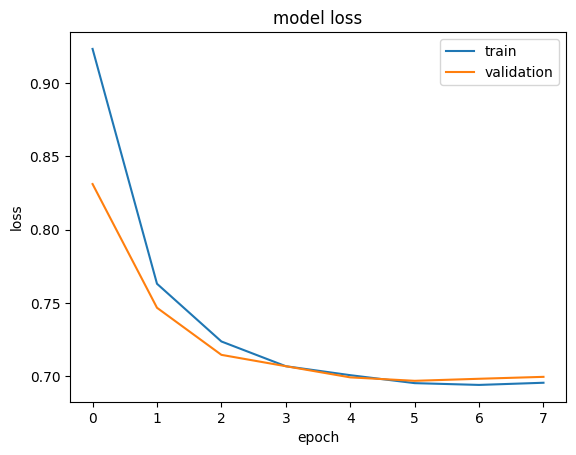

In [46]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Classification

In [47]:
encoder_model = Model(inputs=autoencoder3.input, outputs=autoencoder3.get_layer(index=4).output)

classifier = Sequential([
    Dense(3, activation="softmax")  #output layer (3 classes)
])

#compiling the classifier
classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')


In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history=classifier.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val), shuffle = True,callbacks=[early_stopping])


Epoch 1/200
32/32 [==============================] - 0s 6ms/step - loss: 1.2604 - val_loss: 1.1547
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0843 - val_loss: 1.0877
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0462 - val_loss: 1.0570
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 1.0178 - val_loss: 1.0365
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9980 - val_loss: 1.0188
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9813 - val_loss: 1.0058
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9678 - val_loss: 0.9940
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9583 - val_loss: 0.9850
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9498 - val_loss: 0.9772
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 0.9425 - val_loss: 0.9723
Epoch 11/

# Plot

dict_keys(['loss', 'val_loss'])


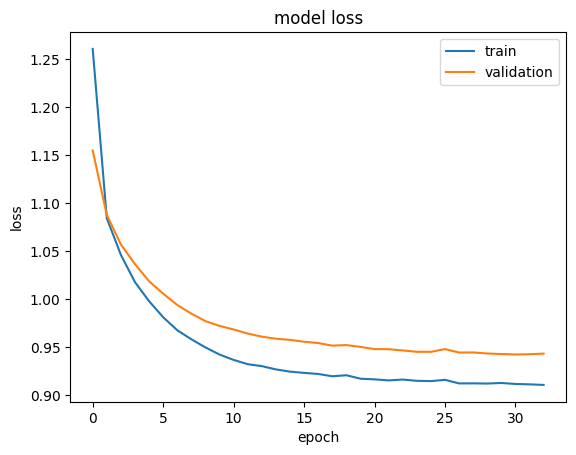

In [50]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Test

In [52]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.2456    0.0427    0.0727       328
           1     0.5862    0.8609    0.6975       604
           2     0.5763    0.5587    0.5674       392

    accuracy                         0.5687      1324
   macro avg     0.4694    0.4874    0.4459      1324
weighted avg     0.4989    0.5687    0.5042      1324



In [ ]:
#############################################################################################################################################################################################

# SMOTE with Simple Autoencoder
you need to run the import cell and the first cell at the beginning then run the cell below for preprocessing 


In [98]:
#applying SMOTE only on training data to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#printing class distributions
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))


scaler = StandardScaler()
scaler.fit(X_train_resampled) 
X_train_resampled = scaler.transform(X_train_resampled)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Original class distribution: Counter({1: 1866, 2: 1111, 0: 995})
Resampled class distribution: Counter({0: 1866, 2: 1866, 1: 1866})


In [99]:
input_size = 70
hidden_size = 1000
bottleneck_size = 1000 
output_size = 70

In [100]:

input_layer = Input(shape=(input_size,))

encoder = Dense(hidden_size, activation="relu")(input_layer)


bottleneck = Dense(bottleneck_size, activation="relu")(encoder) 


decoder = Dense(hidden_size, activation="relu")(bottleneck)

output_layer = Dense(input_size, activation="sigmoid")(decoder)  

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

In [101]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = autoencoder.fit(X_train_resampled, X_train_resampled, epochs=200, batch_size=128, validation_data=(X_val, X_val),shuffle=True, callbacks=[early_stopping])

Epoch 1/200
44/44 [==============================] - 2s 26ms/step - loss: 0.7279 - val_loss: 0.6601
Epoch 2/200
44/44 [==============================] - 1s 21ms/step - loss: 0.6051 - val_loss: 0.6110
Epoch 3/200
44/44 [==============================] - 1s 23ms/step - loss: 0.5841 - val_loss: 0.5995
Epoch 4/200
44/44 [==============================] - 1s 22ms/step - loss: 0.5738 - val_loss: 0.5909
Epoch 5/200
44/44 [==============================] - 1s 22ms/step - loss: 0.5699 - val_loss: 0.5877
Epoch 6/200
44/44 [==============================] - 1s 23ms/step - loss: 0.5683 - val_loss: 0.5866
Epoch 7/200
44/44 [==============================] - 1s 22ms/step - loss: 0.5672 - val_loss: 0.5859
Epoch 8/200
44/44 [==============================] - 1s 23ms/step - loss: 0.5668 - val_loss: 0.5847
Epoch 9/200
44/44 [==============================] - 1s 20ms/step - loss: 0.5663 - val_loss: 0.5846
Epoch 10/200
44/44 [==============================] - 1s 21ms/step - loss: 0.5661 - val_loss: 0.5844

# Plot

dict_keys(['loss', 'val_loss'])


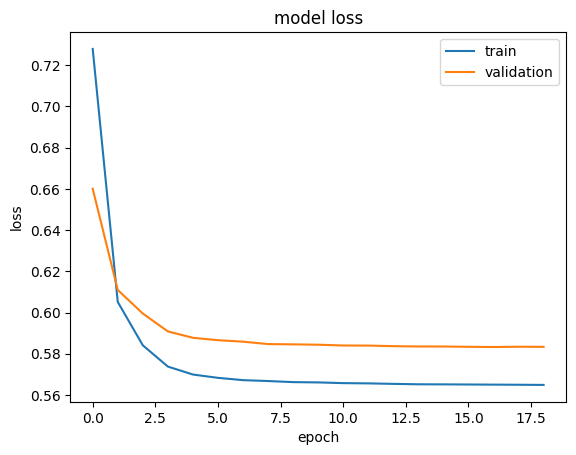

In [102]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# Classification with softmax

In [103]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=2).output)

In [104]:

classifier = Sequential([
    Dense(3, activation="softmax", input_shape=(X_train_resampled.shape[1],)) 
])

classifier.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
classifier.fit(X_train_resampled, y_train_resampled, epochs=200, batch_size=128, validation_data=(X_val, y_val),shuffle=True, callbacks=[early_stopping])

Epoch 1/200
44/44 [==============================] - 0s 4ms/step - loss: 1.1784 - val_loss: 1.1295
Epoch 2/200
44/44 [==============================] - 0s 2ms/step - loss: 1.0660 - val_loss: 1.0713
Epoch 3/200
44/44 [==============================] - 0s 2ms/step - loss: 1.0275 - val_loss: 1.0391
Epoch 4/200
44/44 [==============================] - 0s 2ms/step - loss: 1.0022 - val_loss: 1.0181
Epoch 5/200
44/44 [==============================] - 0s 2ms/step - loss: 0.9851 - val_loss: 1.0047
Epoch 6/200
44/44 [==============================] - 0s 2ms/step - loss: 0.9731 - val_loss: 0.9952
Epoch 7/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9637 - val_loss: 0.9880
Epoch 8/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9563 - val_loss: 0.9818
Epoch 9/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9516 - val_loss: 0.9814
Epoch 10/200
44/44 [==============================] - 0s 2ms/step - loss: 0.9469 - val_loss: 0.9789
Epoch 11/

dict_keys(['loss', 'val_loss'])


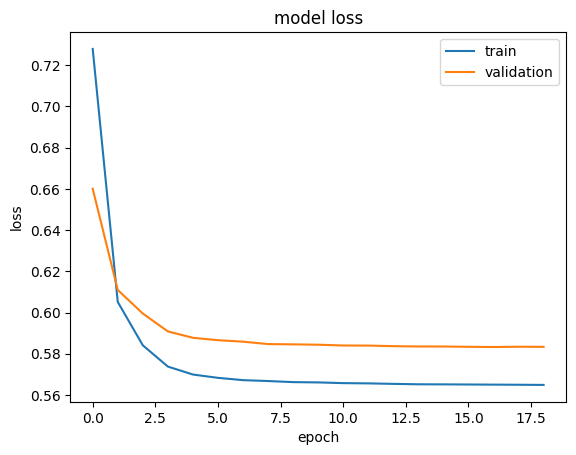

In [105]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [106]:
from sklearn.metrics import classification_report


y_pred_prob = classifier.predict(X_test)

#converting to class labels
y_pred = y_pred_prob.argmax(axis=1)  #getting class with highest probability

print(classification_report(y_test, y_pred, digits=4))

42/42 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.2802    0.3110    0.2948       328
           1     0.6642    0.5960    0.6283       604
           2     0.5502    0.5867    0.5679       392

    accuracy                         0.5227      1324
   macro avg     0.4982    0.4979    0.4970      1324
weighted avg     0.5353    0.5227    0.5278      1324

